In [26]:
import torch
from torch import nn
from torchsummary import summary
import matplotlib.pyplot as plt
import os

In [27]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [28]:
discriminator = nn.Sequential(
 nn.Linear(2, 25),
 nn.ReLU(),
 nn.Dropout(0.3),
 nn.Linear(25, 1),
 nn.Sigmoid()).to(device)

In [29]:
class Generator(nn.Module):
    def __init__(self, latent_dim, n_outputs = 2):
        super().__init__()
        self.l1 = nn.Linear(latent_dim, 15)
        self.relu = nn.ReLU()
        torch.nn.init.kaiming_normal_(self.l1.weight)
        self.l2 = nn.Linear(15, n_outputs)

    def forward(self, x):
        out = self.relu((self.l1(x)))
        out = self.l2(out)
        return out

In [30]:
def define_gan(generator, discriminator):

    model = nn.Sequential()
    model.add_module('generator', generator)
    model.add_module('discriminator', discriminator)

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters())
    return model.to(device), criterion, optimizer

In [31]:
generator = Generator(5, n_outputs=2).to(device)
gan_model, criterion, optimizer = define_gan(generator, discriminator)
summary(gan_model, (1,5))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 15]              90
              ReLU-2                [-1, 1, 15]               0
            Linear-3                 [-1, 1, 2]              32
         Generator-4                 [-1, 1, 2]               0
            Linear-5                [-1, 1, 25]              75
              ReLU-6                [-1, 1, 25]               0
           Dropout-7                [-1, 1, 25]               0
            Linear-8                 [-1, 1, 1]              26
           Sigmoid-9                 [-1, 1, 1]               0
Total params: 223
Trainable params: 223
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
---------------------------------------------------

In [32]:
from numpy.random import rand, randn
from numpy import hstack, ones, zeros

def generate_real_samples(n):
  X1 = rand(n) - 0.5
  X2 = X1 * X1
  X1 = X1.reshape(n, 1)
  X2 = X2.reshape(n, 1)
  X = hstack((X1, X2))
  y = ones((n, 1))
  return X, y

def generate_latent_points(latent_dim, n):
  x_input = randn(latent_dim * n)
  x_input = x_input.reshape(n, latent_dim)
  return x_input

def generate_fake_samples(generator, latent_dim, n):
  x_input = generate_latent_points(latent_dim, n)
  X = generator(torch.Tensor(x_input).to(device))
  y = zeros((n, 1))
  return X.cpu().detach().numpy(), y

In [33]:
def summarize_performance(epoch, g_model, d_model, latent_dim, n=100):
  x_real, y_real = generate_real_samples(n)
  x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n)
  g_model.eval()
  d_model.eval()
  plt.scatter(x_real[:, 0], x_real[:, 1], color="red")
  plt.scatter(x_fake[:, 0], x_fake[:, 1], color="blue")
  if not os.path.exists('generated'):
        os.makedirs('generated')
  filename = "generated/generated_plot_e%03d.png" % (epoch+1)
  plt.savefig(filename)
  plt.close()

In [34]:
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=128, n_eval=2000):
  d_model_optimizer = torch.optim.Adam(d_model.parameters())
  half_batch = int(n_batch / 2)
  for i in range(n_epochs):
    x_real, y_real = generate_real_samples(half_batch)
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)

    for param in discriminator.parameters():
      param.requires_grad = True

    d_model.train()

    d_model_outputs = d_model(torch.Tensor(x_real).to(device))
    loss = criterion(d_model_outputs, torch.Tensor(y_real).to(device))
    d_model_optimizer.zero_grad()
    loss.backward()
    d_model_optimizer.step()

    d_model_outputs = d_model(torch.Tensor(x_fake).to(device))
    loss = criterion(d_model_outputs, torch.Tensor(y_fake).to(device))
    d_model_optimizer.zero_grad()
    loss.backward()
    d_model_optimizer.step()

    for param in discriminator.parameters():
      param.requires_grad = False

    x_gan = generate_latent_points(latent_dim, n_batch)
    y_gan = ones((n_batch, 1))
    gan_model.train()
    gan_model_outputs = gan_model(torch.Tensor(x_gan).to(device))
    loss = criterion(gan_model_outputs, torch.Tensor(y_gan).to(device))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (i+1) % n_eval == 0:
      summarize_performance(i, g_model, d_model, latent_dim)

latent_dim = 5
train(generator, discriminator, gan_model, latent_dim, 100000)

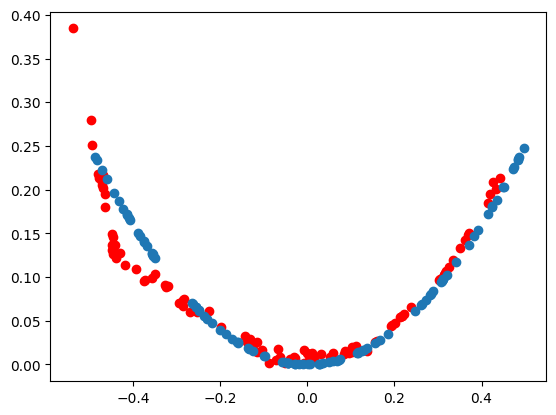

In [35]:
x, _ = generate_real_samples(100)
x2, _ = generate_fake_samples(generator, 5, 100)
plt.scatter(x2[:,0], x2[:,1], color='red')
plt.scatter(x[:,0], x[:,1]);